# Neural Netowork Classification

### 1. Making Custom Dataset
We will be using sklearn's make_circles which creats data points in the form of concentric circles on a graph. We can add noise in it. It is mainly used for classification and clustering purposes.

In [1]:
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42) #random_state is like manual seed
print(X[:5], X.shape) 
print(y[:5], y.shape)

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] (1000, 2)
[1 1 1 1 0] (1000,)


### 1. Creating a pandas Dataframe 
We have 2 features in X and 2 classes in y ie binary data

In [2]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "y": y})
circles.head()

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


### 2. Visualizing the dataset

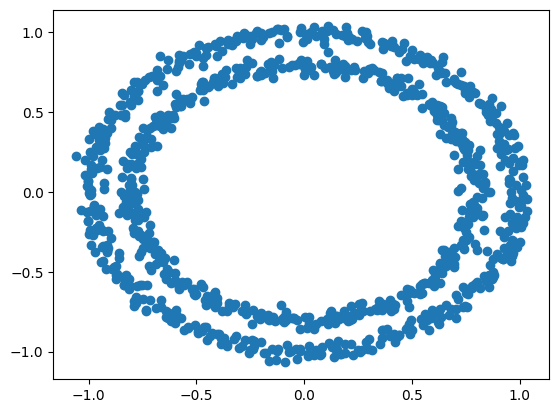

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1])
#We can see 2 classes of data points

### 3. Converting Data into pytorch tensors. 

In [4]:
print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [5]:
#Turning the numoy array into pytorch tensor
import torch
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)
X = X.to(device='cuda')
y = y.to(device='cuda')

### 4. Train Test Splitting

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [7]:
print(len(X_train), len(X_test), len(y_train), len(y_test), X.device, y.device)

800 200 800 200 cuda:0 cuda:0


## 5. Building the Model
* ### Creating the model class manually
We need to manually override the forward function here by returning value of x passing through all the layers. But when the number of parameters and layers increase, it will not be feasible. So we use nn.Sequential which does this entire process for us. We can directly define a model object or we can also create an nn.module subclass using nn.Sequential inside it.

In [8]:
from torch import nn
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5) #takes in the input
        self.layer_2 = nn.Linear(in_features=5, out_features=1) #hidden layer

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to('cuda')
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.6253,  0.2811],
                      [-0.6241, -0.2900],
                      [-0.2796,  0.4340],
                      [-0.6179, -0.3549],
                      [-0.4196, -0.2804]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.5992,  0.2482, -0.3010,  0.6334,  0.5086], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.0922,  0.3691,  0.1306, -0.1760, -0.1293]], device='cuda:0')),
             ('layer_2.bias', tensor([0.3984], device='cuda:0'))])

* ### Creating model using nn.Sequential()
This is very useful for creating a small simple model quickly

In [9]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to('cuda')
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5419,  0.5811],
                      [-0.2261, -0.0311],
                      [ 0.4305, -0.1732],
                      [ 0.4116,  0.5501],
                      [ 0.6027,  0.1178]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1555,  0.0890, -0.6885,  0.2237,  0.1015], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3339,  0.3235, -0.2107,  0.0491,  0.0460]], device='cuda:0')),
             ('1.bias', tensor([0.2318], device='cuda:0'))])

* ### Creating a model class using nn.Sequential()
This is the best way for creating a model

In [10]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.two_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        return self.two_layers(x)

model_2 = CircleModelV2().to('cuda')
model_2.state_dict()

OrderedDict([('two_layers.0.weight',
              tensor([[-0.0038, -0.4500],
                      [-0.5755, -0.5781],
                      [ 0.1710,  0.2434],
                      [ 0.5254,  0.0414],
                      [ 0.5889,  0.0316]], device='cuda:0')),
             ('two_layers.0.bias',
              tensor([-0.5365,  0.3117,  0.4065, -0.6669, -0.1162], device='cuda:0')),
             ('two_layers.1.weight',
              tensor([[ 0.3097, -0.1316,  0.1402, -0.1477,  0.0411]], device='cuda:0')),
             ('two_layers.1.bias', tensor([0.3592], device='cuda:0'))])

### 6. Chossing loss function and Optimizer
For classification problems, we can use binary cross entropy or categorical cross entropy as loss functions and SGD or adam as optimizer.

In [11]:
#Choosing loss function
#loss_fn = nn.BCELoss() #this requires inputs to have gone through sigmoid prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = has sigmoid activation function builtin.
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

### 7.Writing a function to calculate accuracy 

In [12]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

* ## Raw Logit -> Prediction Probability -> Prediction Labels

We need to convert these logits to prediction possibilties. The **sigmoid activation function** does this for binary data and the **softmax()** activation function for multiclass data. These functions convert the raw **logits** into **prediction probabilities**.

Now in order to convert the **prediction probabilities** into **prediction labels**, we either need to **round** the data for binary output or use **argmax()** for multiclass output.

### 8. Training the Model

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
for epoch in range(epochs):
    #Training Loop
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
  # loss = loss_fn(torch.sigmoid(y_logits), y_train)  #if BCE was used, it takes prediction probabilites as input
    loss = loss_fn(y_logits, y_train) #BCELossWithLogits take raw logits as input
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Training Loop
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        accuracy = accuracy_fn(y_true = y_test, y_pred = test_preds)

    #printing out 
    if(epoch%10==0):
        print(f"epoch: {epoch} | train_loss: {loss} | test_loss: {test_loss} | accuracy: {accuracy}")

epoch: 0 | train_loss: 0.7048342823982239 | test_loss: 0.7032040357589722 | accuracy: 50.0
epoch: 10 | train_loss: 0.6974232792854309 | test_loss: 0.6969656348228455 | accuracy: 50.0
epoch: 20 | train_loss: 0.6949863433837891 | test_loss: 0.6950106620788574 | accuracy: 51.5
epoch: 30 | train_loss: 0.6941635012626648 | test_loss: 0.694405198097229 | accuracy: 55.50000000000001
epoch: 40 | train_loss: 0.6938570737838745 | test_loss: 0.694210946559906 | accuracy: 52.5
epoch: 50 | train_loss: 0.6937170028686523 | test_loss: 0.6941389441490173 | accuracy: 53.5
epoch: 60 | train_loss: 0.6936327815055847 | test_loss: 0.6941036581993103 | accuracy: 52.5
epoch: 70 | train_loss: 0.6935697793960571 | test_loss: 0.6940811276435852 | accuracy: 51.5
epoch: 80 | train_loss: 0.693516731262207 | test_loss: 0.6940646767616272 | accuracy: 52.0
epoch: 90 | train_loss: 0.6934698224067688 | test_loss: 0.6940528154373169 | accuracy: 52.5


## Troubleshooting
* ### Decision Tree Visualization
Our model seems to do pretty bad and we can visualize our model's decision boundary using functions from helper_functions.py provided by pytorch which we need to download first.


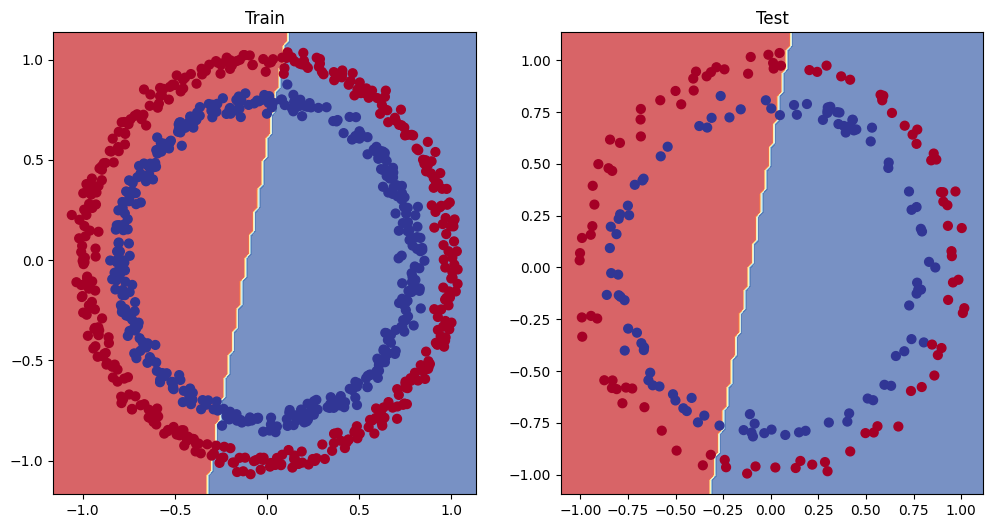

In [14]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

### What can we do 
* We can add more layers
* We can add more hidden nodes per layer
* Increasing the number of epochs
* We can see that the model is drawing a linear line to divide the data, we need to remove this non-linearity 

* ### Adding ReLu (rectified linear unit) between the hidden layers using nn.Relu()

In [15]:
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1),
        )

    def forward(self, x):
        return self.layers(x)

model_3 = CircleModelV3().to('cuda')

In [16]:
loss_fn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(params = model_3.parameters(), lr = 0.1)

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1700
for epoch in range(epochs):
    #Training Loop
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
  # loss = loss_fn(torch.sigmoid(y_logits), y_train)  #if BCE was used, it takes prediction probabilites as input
    loss = loss_fn(y_logits, y_train) #BCELossWithLogits take raw logits as input
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Training Loop
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        accuracy = accuracy_fn(y_true = y_test, y_pred = test_preds)

    #printing out 
    if(epoch%10==0):
        print(f"epoch: {epoch} | train_loss: {loss} | test_loss: {test_loss} | accuracy: {accuracy}")

epoch: 0 | train_loss: 0.6929463148117065 | test_loss: 0.6931881308555603 | accuracy: 50.0
epoch: 10 | train_loss: 0.6924761533737183 | test_loss: 0.6925959587097168 | accuracy: 50.0
epoch: 20 | train_loss: 0.6922457218170166 | test_loss: 0.6923112273216248 | accuracy: 56.49999999999999
epoch: 30 | train_loss: 0.6920924782752991 | test_loss: 0.6921225786209106 | accuracy: 68.0
epoch: 40 | train_loss: 0.6919483542442322 | test_loss: 0.6919479966163635 | accuracy: 71.0
epoch: 50 | train_loss: 0.6918084025382996 | test_loss: 0.6917727589607239 | accuracy: 57.99999999999999
epoch: 60 | train_loss: 0.6916753053665161 | test_loss: 0.691611647605896 | accuracy: 54.50000000000001
epoch: 70 | train_loss: 0.691547691822052 | test_loss: 0.6914635300636292 | accuracy: 53.0
epoch: 80 | train_loss: 0.6914128065109253 | test_loss: 0.6913154721260071 | accuracy: 53.0
epoch: 90 | train_loss: 0.6912803649902344 | test_loss: 0.6911686062812805 | accuracy: 53.0
epoch: 100 | train_loss: 0.691152811050415 |

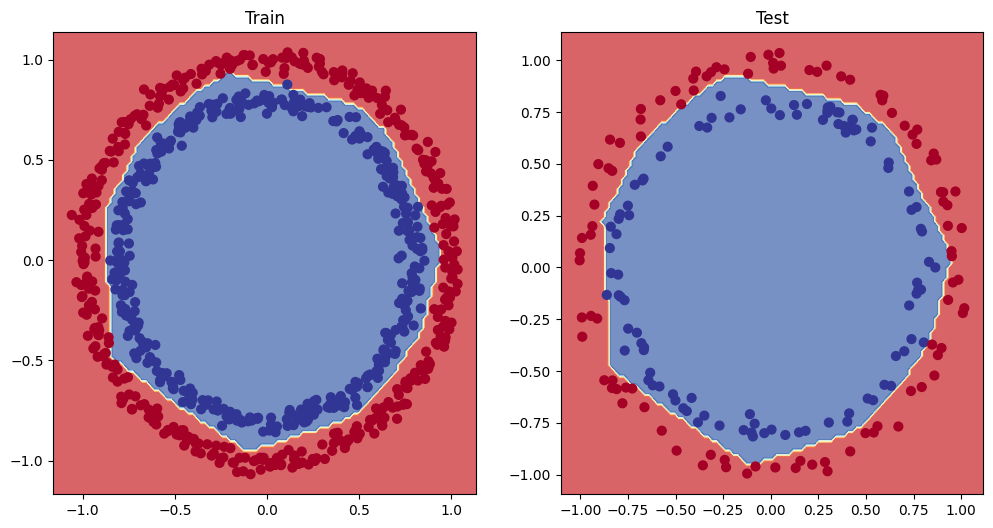

In [18]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)